# IIC-2433 Minería de Datos UC

- Versiones de librerías, python 3.8.10

- numpy 1.20.3
- sklearn 1.3.1
- DoWhy 0.12
- scipy 1.15.3

In [1]:
!pip3 install DoWhy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


## Modelo GPS-Memoria

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

import dowhy
from dowhy import CausalModel

In [3]:
class GPSMemorySCM:
    
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_x = stats.truncnorm(0, np.infty, scale=5)
        self.u_y = stats.norm(scale=2)
        self.u_z = stats.norm(scale=2)
        self.u = stats.truncnorm(0, np.infty, scale=4)
        
    def sample(self, sample_size=100, treatment_value=None):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        u = self.u.rvs(sample_size)
        
        if treatment_value:
            gps = np.array([treatment_value]*sample_size)
        else:
            gps = u_x + 0.7*u
            
        hippocampus = -0.6*gps + 0.25*u_z
        memory = 0.7*hippocampus + 0.25*u
        
        return gps, hippocampus, memory
    
    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

In [4]:
# Instantiate the SCM
scm = GPSMemorySCM()

# Generate observational data
gps_obs, hippocampus_obs, memory_obs = scm.sample(1000)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([gps_obs, hippocampus_obs, memory_obs]).T, columns=['X', 'Z', 'Y'])

In [5]:
df

,X,Z,Y
0,4.112216,-2.145154,-0.416641
1,5.033208,-3.557968,-1.715015
2,2.072369,-0.980547,-0.156815
3,4.945853,-2.637407,-0.785717
4,6.507559,-3.719618,-1.959987
...,...,...,...
995,5.246228,-3.577730,-1.520773
996,6.546688,-4.235398,-1.465884
997,9.374855,-5.489424,-3.496549
998,9.176765,-4.474747,-2.941831


In [6]:
gml_graph = """
graph [
    directed 1
    
    node [
        id "X" 
        label "X"
    ]    
    node [
        id "Z"
        label "Z"
    ]
    node [
        id "Y"
        label "Y"
    ]
    node [
        id "U"
        label "U"
    ]
    
    edge [
        source "X"
        target "Z"
    ]
    edge [
        source "Z"
        target "Y"
    ]
    edge [
        source "U"
        target "X"
    ]
    edge [
        source "U"
        target "Y"
    ]
]
"""

In [7]:
model = CausalModel(
    data=df,
    treatment='X',
    outcome='Y',
    graph=gml_graph
)

/home/marcelo/.local/lib/python3.10/site-packages/dowhy/causal_model.py:583: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


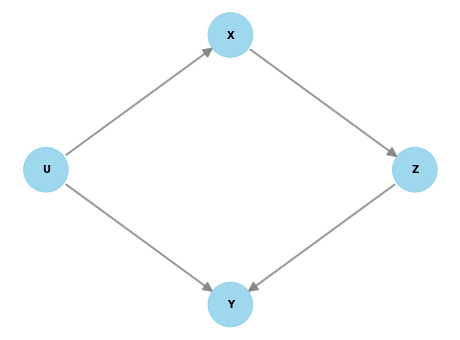

In [8]:
model.view_model()

In [9]:
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Full-mediation: Z intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)



In [10]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='frontdoor.two_stage_regression')

print(f'Estimate of causal effect (linear regression): {estimate.value}')

Estimate of causal effect (linear regression): -0.4171837461368608


/home/marcelo/.local/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/marcelo/.local/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
